In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.serialization

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

In [2]:
from umap import UMAP
import hdbscan
import datamapplot

In [3]:
torch.manual_seed(1337)
random.seed(1337)

def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [4]:
data_dir = Path('/Users/djemec/data/jepa/v0_4')
mask_path = data_dir / 'binary_pathway_mask.npy'
pert_dir = data_dir / 'pert_embd'
metadata_path = pert_dir / 'pert_to_id.json'
checkpoint_dir = Path('/Users/djemec/data/jepa/v0_5') / 'checkpoints'
gene_names_path = data_dir / 'gene_names.json'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

## Load Model Checkpoint

In [5]:
import biojepa_ac_v0_5 as model
from biojepa_ac_v0_5 import BioJepaConfig

batch_size = 32
n_embd = 8
training_file_chunk = 25000
n_layers = 2
n_heads = 2
n_genes = 5000
pert_latent_dim = 320
pert_mode_dim = 64

training_file_chunk = 10000
pretraining_file_chunk = 50000

In [6]:
print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

with open(gene_names_path, 'r') as f:
    gene_names = json.load(f)
print(f'Loaded {len(gene_names)} genes')

Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)
Loaded 5000 genes


In [7]:
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'
pert_embd = np.load(pert_embd_path)

In [8]:
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers,
    pert_latent_dim=pert_latent_dim,
    pert_mode_dim=pert_mode_dim
)
model = model.BioJepa(config)

In [9]:
checkpoint_path = checkpoint_dir / 'bio_jepa_pt_ckpt_35109_final.pt'
with torch.serialization.safe_globals([BioJepaConfig]):
    checkpoint = torch.load(checkpoint_path)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

In [10]:
gene_embd = model.student.gene_embeddings.detach().cpu().float().numpy()
embd = gene_embd
gene_embd.shape

(5000, 8)

In [11]:
n = gene_embd.shape[0]
n

5000

In [14]:
labels = np.asarray(gene_names) 

## Load Perturbation Embeddings

In [6]:
pert_id_file = pert_dir / 'pert_to_id.json'
pert_embd_file = pert_dir / 'action_embeddings_esm2.npy'

In [7]:
pert_embd = np.load(pert_embd_file)
pert_embd.shape

(1087, 320)

In [8]:
with open(pert_id_file, 'r') as f:
    pert_to_id = json.load(f)
all_perts = [i for i in pert_to_id.keys() if i != 'control']
len(all_perts)

1087

In [9]:
n = pert_embd.shape[0]
embd = pert_embd
n

1087

In [10]:
labels = np.asarray(all_perts) 

## Visualizations

In [15]:
coords = UMAP(
    n_components=2, 
    n_neighbors=30, 
    min_dist=0.5, 
    spread=2.0, 
    metric="cosine", 
    random_state=0).fit_transform(embd)

/opt/miniconda3/envs/general/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<InteractiveFigure width=100% height=800>
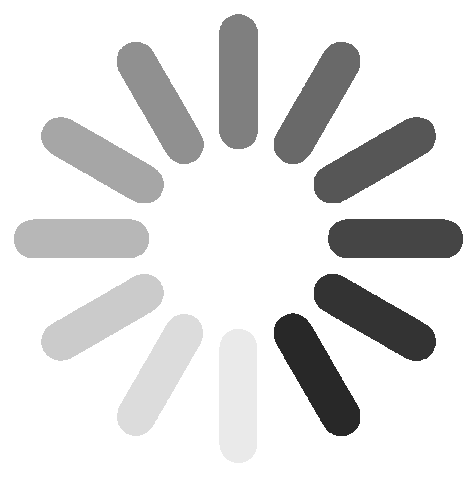

In [16]:
datamapplot.create_interactive_plot(coords, labels)

In [17]:
from sklearn.manifold import TSNE

In [18]:
coords = TSNE(
    n_components=2,
    perplexity=30,      
    learning_rate='auto',
    init='random',
    random_state=12
).fit_transform(embd)

<InteractiveFigure width=100% height=800>
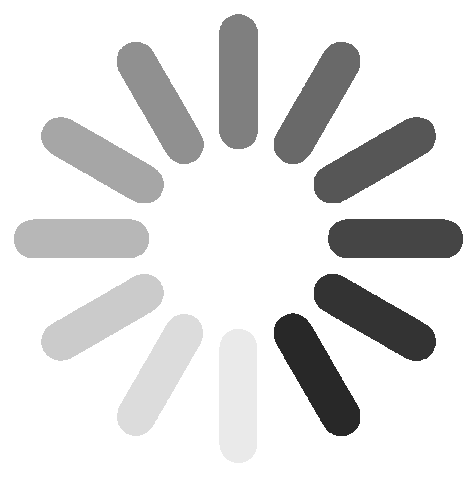

In [19]:
datamapplot.create_interactive_plot(coords, labels)